Intento de crear una CGAN con los datos de minecraft

MEJORAS APLICADAS
el embeding y el ruido se normalizan (para q uno no se coma al otro en la generacion)

posibles mejoras
ponderacion aprendida de ruido y embedings para que genere imagenes más variadas con el mismo prompt
proyectar el embedding y sumarlo al vector latente (en vez de concatenar)
ponderar el embeding frente al ruido (para considerarlo mas)
reducir la dimension del espacio latente 


v1: demsiado poco continuo (muy poco suave), generador muy condicionado (poco ruido creo) 

usamos un pack de texturas con superresolucion por defecto
añadimos más capas al tener maás pixeles

## Data

In [75]:
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import re
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df=pd.read_parquet("../datos/faithful_1.21.1_32.parquet")

## Code

informacion relevante:
las imagenes componen valores entre [-1,1] por eso se usa funcion tanh y no sigmoid

In [76]:
"""def mostrar_imagen(row):
    
    # Muestra una imagen y su etiqueta desde una fila del DataFrame.
    
    # Obtener los bytes de la imagen
    image_bytes = row['image']['bytes']

    img = Image.open(io.BytesIO(image_bytes))
    
    # Mostrar imagen con su etiqueta
    plt.imshow(img)
    plt.axis("off")
    plt.title(row['label'])
    plt.show()
    """

def mostrar_resultados(resultados):
    """
    Muestra una lista de imágenes generadas con sus etiquetas.
    """
    plt.figure(figsize=(8, 2))
    for i, (img, label) in enumerate(resultados):
        plt.subplot(1, len(resultados), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()


def generar_imagenes(G, text_embedding, prompt: str, nz=100, n_samples=4, device="cuda"):
    """
    Genera imágenes condicionales a partir de un prompt textual.

        G: Modelo generador.
        text_embedding: Módulo TextEmbedding.
        prompt: Texto de entrada 
        nz: Tamaño del vector de embeding (ruido==embedding de texto)
        n_samples: Número de imágenes a generar.

    Devuelve:
        Lista de tuplas (img_pil, prompt)
    """
    G.eval()
    text_embedding.eval()

    with torch.no_grad():
        # Embedding condicional del texto
        cond_emb = text_embedding([prompt] * n_samples).to(device)

        # Ruido aleatorio
        z = torch.randn(n_samples, nz, device=device)

        # Generar imágenes
        fake_imgs = G(z, cond_emb).detach().cpu()

        # Desnormalizar
        fake_imgs = (fake_imgs * 0.5 + 0.5).clamp(0, 1)

        # Convertir a PIL y devolver
        results = []
        for i in range(n_samples):
            img_pil = TF.to_pil_image(fake_imgs[i])
            results.append((img_pil, prompt))
    
    return results


def total_variation_loss(img): 
    """introducir penalizacion a que las imagenes no sean continuas"""
    diff_i = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    diff_j = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
    return diff_i + diff_j


# Dataset único (con augment)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=32, augment=False):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)])

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# Embedding textual (por palabra)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=128, proj_dim=100):
        super().__init__()
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)
        self.proj = nn.Linear(embed_dim, proj_dim)  # fija dim de salida del embeding
        self.dropout = nn.Dropout(0.1)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.embedding.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        x = torch.stack(vectors)
        x = self.proj(x)
        x = self.dropout(x)
        return x  # shape [B, proj_dim]


#### Crear Modelo

In [77]:
import torch
import torch.nn as nn

# Generator (3 capas + salida, suma de nz y cond_emb en vez de concatenar)
class Generator(nn.Module):
    def __init__(self, embed_dim=100, ngf=32, out_channels=3):
        super().__init__()
        assert embed_dim == embed_dim, "Para sumar z y cond_emb, ambas dimensiones deben coincidir."

        # Proyección inicial → 4×4
        self.fc = nn.Linear(embed_dim, ngf * 8 * 4 * 4)

        self.net = nn.Sequential(
            # 4×4 → 8×8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 8×8 → 16×16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Capa adicional (16×16 → 32×32)
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Salida (32×32)
            nn.ConvTranspose2d(ngf, out_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, cond_emb):
        # Normalizar
        z_norm = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        cond_norm = cond_emb / (cond_emb.norm(dim=1, keepdim=True) + 1e-8)
        
        x = z_norm + cond_norm # Sumar embeddings
        x = self.fc(x)
        x = x.view(x.size(0), -1, 4, 4)
        
        return self.net(x)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, embed_dim=100, ndf=32, in_channels=3):
        super().__init__()
        self.fc_cond = nn.Linear(embed_dim, 32 * 32)  # cond_map → 32×32

        self.net = nn.Sequential(
            # 4 canales → 32×32 → 16×16
            nn.Conv2d(in_channels + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 16×16 → 8×8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 8×8 → 4×4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # salida (4×4 → escalar)
            nn.Flatten(),
            nn.Linear(ndf * 4 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img, cond_emb):
        B, C, H, W = img.shape
        cond_map = self.fc_cond(cond_emb).view(B, 1, H, W)
        x = torch.cat([img, cond_map], dim=1)
        return self.net(x).view(-1)


In [78]:
embed_dim = 128      # dimensión del embedding textual
proj_dim= 100        # dimesión de salida del embedding textual

batch_size = 32
      
num_epochs = 2000
lr = 1e-4 
beta1 = 0.5

# parametros del generador
lambda_tv = 0.1  # intensidad de la correccion del suavizado  menor que antes (antes 0.1)
lambda_l2 = 0.03  # peso del L2 (ajústalo entre 0.01 y 0.2)      mayor que antes (antes 0.05)


In [79]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))

vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=32, augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 350 palabras únicas:


#### Entrenamiento

In [80]:
# MODELOS
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim,proj_dim=proj_dim).to(device)
G = Generator(embed_dim=proj_dim).to(device)
D = Discriminator(embed_dim=proj_dim).to(device)


In [81]:
# Pérdida y optimizadores
criterion = nn.BCELoss()
optimizerG = optim.Adam(
    list(G.parameters()) + list(txt_emb.parameters()),
    lr=lr, betas=(beta1, 0.999))

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Época [0/2000] Loss_D: 0.9066  Loss_G: 0.7952


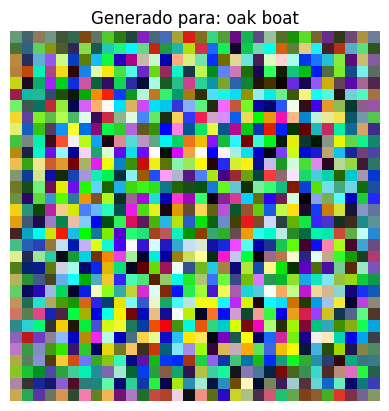

Época [100/2000] Loss_D: 0.4608  Loss_G: 1.3387


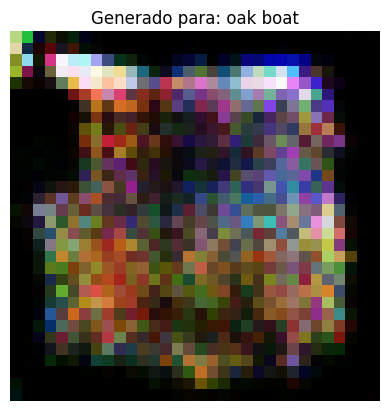

Época [200/2000] Loss_D: 0.5630  Loss_G: 1.2576


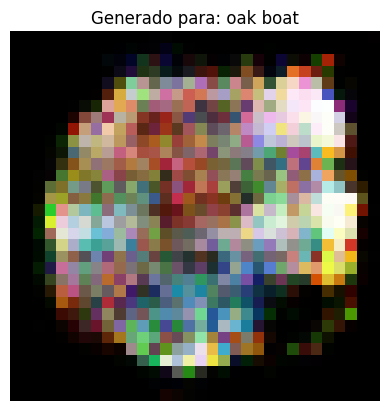

Época [300/2000] Loss_D: 0.4066  Loss_G: 2.1078


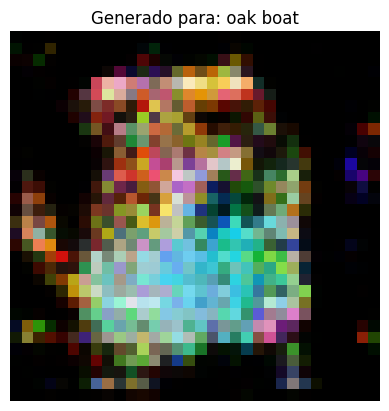

Época [400/2000] Loss_D: 0.4106  Loss_G: 1.7504


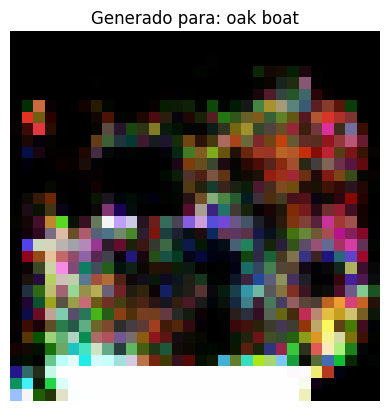

Época [500/2000] Loss_D: 0.3209  Loss_G: 1.9879


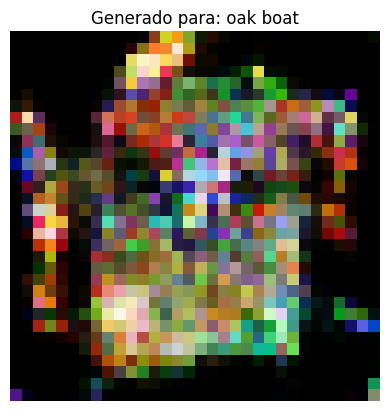

Época [600/2000] Loss_D: 0.4386  Loss_G: 1.8533


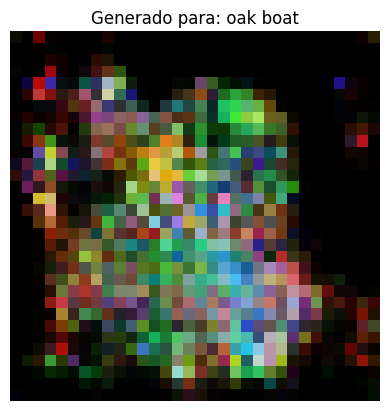

Época [700/2000] Loss_D: 0.2518  Loss_G: 2.4804


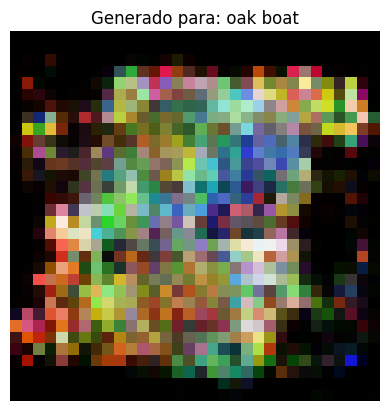

Época [800/2000] Loss_D: 0.2632  Loss_G: 2.7700


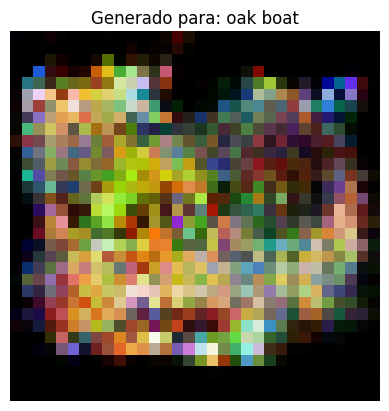

Época [900/2000] Loss_D: 0.2487  Loss_G: 2.7406


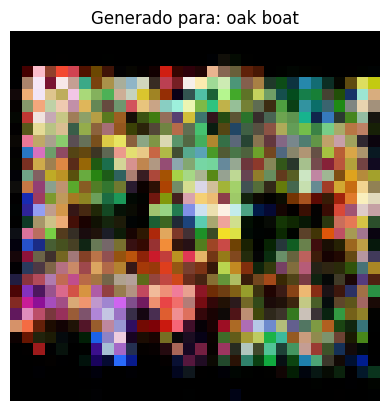

Época [1000/2000] Loss_D: 0.2860  Loss_G: 2.4800


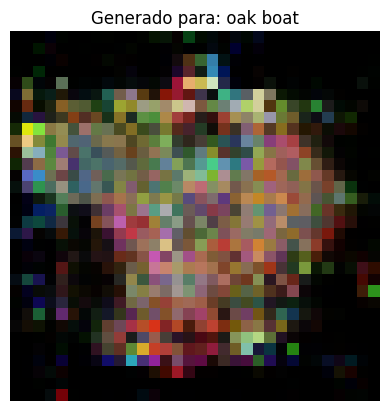

Época [1100/2000] Loss_D: 0.2903  Loss_G: 2.6512


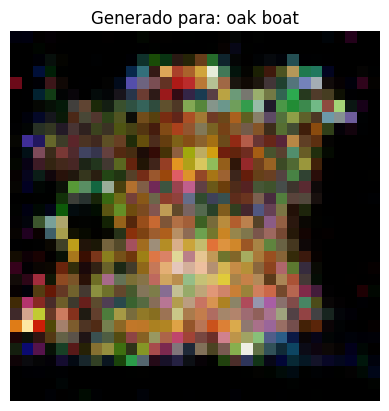

Época [1200/2000] Loss_D: 0.3170  Loss_G: 2.2302


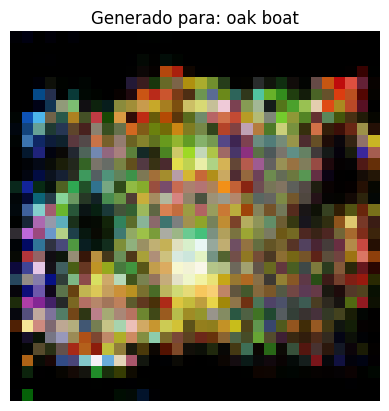

Época [1300/2000] Loss_D: 0.2708  Loss_G: 2.6189


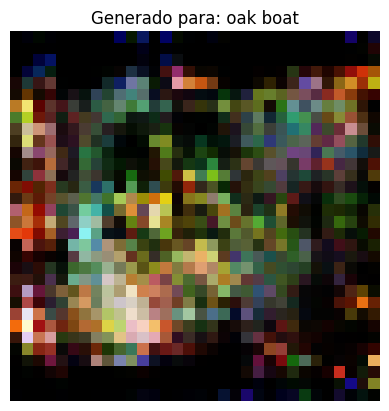

Época [1400/2000] Loss_D: 0.2348  Loss_G: 3.3253


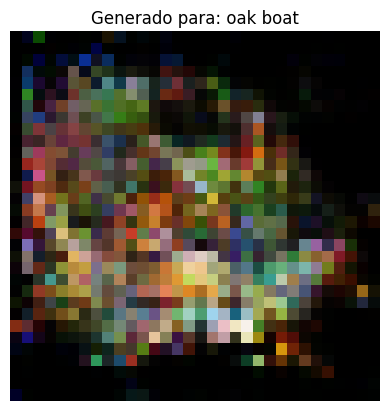

Época [1500/2000] Loss_D: 0.2896  Loss_G: 2.7632


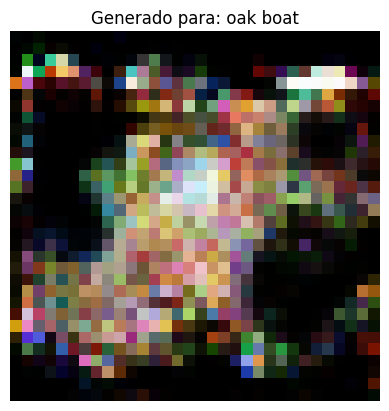

Época [1600/2000] Loss_D: 0.2272  Loss_G: 3.3278


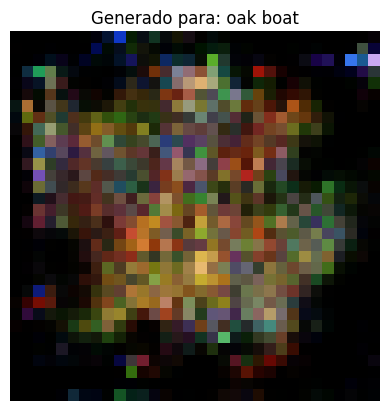

Época [1700/2000] Loss_D: 0.2204  Loss_G: 3.2780


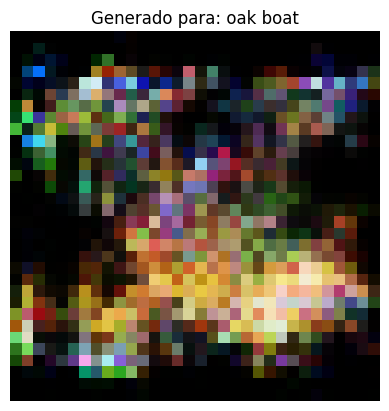

Época [1800/2000] Loss_D: 0.2224  Loss_G: 2.8595


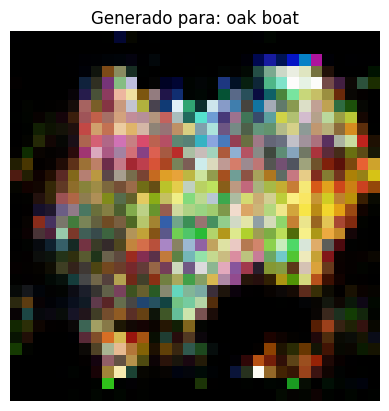

Época [1900/2000] Loss_D: 0.3798  Loss_G: 2.6652


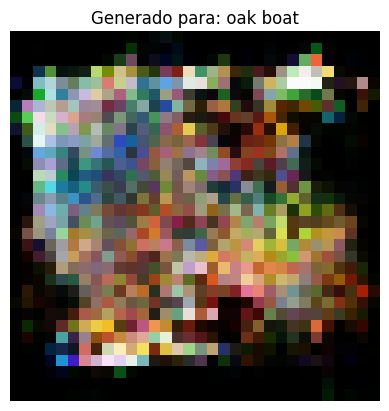

In [82]:
# version primera de la funcion de entrenamiento
for epoch in range(num_epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.to(device)
        cond_emb = txt_emb(labels).to(device)
        b_size = real_imgs.size(0)

        # Etiquetas reales/falsas con label smoothing leve
        real_labels = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)

        # =========================================================
        # (1) Actualizar Discriminator: maximize log(D(x|y)) + log(1 - D(G(z|y)))
        # =========================================================
        D.zero_grad()

        # Salida del D con imágenes reales
        output_real = D(real_imgs, cond_emb)
        lossD_real = criterion(output_real, real_labels)

        # Generar imágenes falsas condicionales
        z = torch.randn(b_size, proj_dim, device=device)
        fake_imgs = G(z, cond_emb)
        output_fake = D(fake_imgs.detach(), cond_emb)
        lossD_fake = criterion(output_fake, fake_labels)

        # Pérdida total del Discriminador
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward(retain_graph=True)
        optimizerD.step()

        # =========================================================
        # (2) Actualizar Generator: maximize log(D(G(z|y)))
        # =========================================================
        G.zero_grad()
        output = D(fake_imgs, cond_emb)
        lossG_adv = criterion(output, real_labels)  # pérdida adversarial
    
        tv_loss = total_variation_loss(fake_imgs) # añadir suavidad
        loss_pixel = F.mse_loss(fake_imgs, real_imgs)  # comparación directa de píxeles

        lossG = lossG_adv + lambda_tv * tv_loss + lambda_l2 * loss_pixel
        lossG.backward()
        optimizerG.step()


    # =========================================================
    # LOGGING
    # =========================================================
    if epoch % 100 == 0:
        print(f"Época [{epoch}/{num_epochs}] "
              f"Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

        # Generar una imagen de ejemplo condicional
        test_prompt = "oak boat"
        test_emb = txt_emb([test_prompt]).to(device)
        z = torch.randn(1, nz, device=device)
        fake_test = G(z, test_emb).detach().cpu()

        import matplotlib.pyplot as plt
        import torchvision.transforms.functional as TF

        img_vis = (fake_test[0] * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(TF.to_pil_image(img_vis))
        plt.title(f"Generado para: {test_prompt}")
        plt.axis("off")
        plt.show()


#### resultados

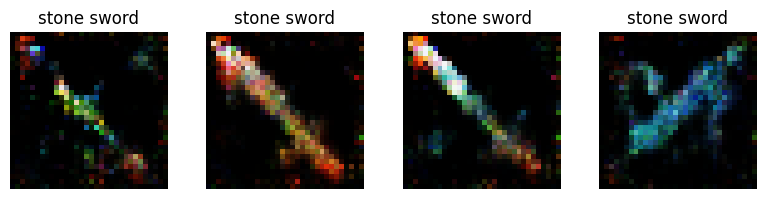

In [83]:
# Generar y mostrar
prompt = "stone sword"
resultados = generar_imagenes(G, txt_emb, prompt)
mostrar_resultados(resultados)

#### Guardar modelos

In [ ]:
# GUARDAR MODELOS
import os
import torch

version = "v1" 
save_dir = f"./modelos/{version}"

os.makedirs(save_dir, exist_ok=True)

# === Guardar modelos ===
torch.save(G.state_dict(), os.path.join(save_dir, "generator.pth"))
torch.save(D.state_dict(), os.path.join(save_dir, "discriminator.pth"))
torch.save(txt_emb.state_dict(), os.path.join(save_dir, "text_embedding.pth"))

print(f" Modelos guardados en: {save_dir}")


 Modelos guardados en: ./modelos/v1


#### Importar modelos

In [ ]:
import torch
import os

# === Configuración ===
device = "cuda" if torch.cuda.is_available() else "cpu"
version = "v1"  
embed_dim = 128 # tamaño del embedding de texto
proj_dim=100
save_dir = f"./modelos/{version}"

# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

# === Inicializar modelos ===
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim,proj_dim=proj_dim).to(device)
G = Generator(embed_dim=proj_dim).to(device)
D = Discriminator(embed_dim=proj_dim).to(device)

# === Cargar pesos ===
G.load_state_dict(torch.load(os.path.join(save_dir, "generator.pth"), map_location=device))
D.load_state_dict(torch.load(os.path.join(save_dir, "discriminator.pth"), map_location=device))
txt_emb.load_state_dict(torch.load(os.path.join(save_dir, "text_embedding.pth"), map_location=device))

# === Pasar a modo evaluación ===
G.eval()
D.eval()
txt_emb.eval()

print(" Modelos cargados correctamente desde", save_dir)


 Modelos cargados correctamente desde ./modelos/v1


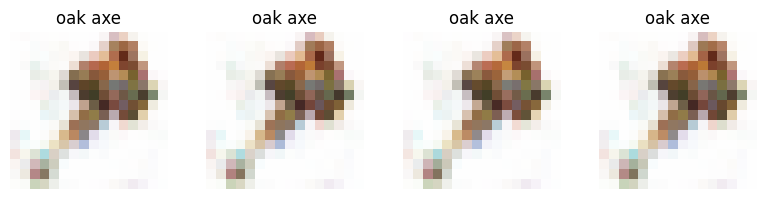

In [ ]:
# Generar y mostrar
prompt = "oak axe"
resultados = generar_imagenes(G, txt_emb, prompt)
mostrar_resultados(resultados)